# XLNet version 1

Hate speech identification project, D7047E <br>
Binary text classification task using pretrained XLNet models

In [1]:
""" 
%pip install numpy
%pip install torch
%pip install torchvision
%pip install sentencepiece
%pip install transformers
%pip install datasets
%pip install evaluate
%pip install accelerate
"""

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torchvision

# Hugging Face
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# Misc
from tqdm import tqdm, trange
import sentencepiece as spm
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using cuda:0


In [2]:
# Constants and vars

# aux files
path_tr = r"..\\OLID_Tain.txt" 
path_te_a = r"..\\OLID_TEST.txt" 
path_te_b = r"..\\OLID_TEST_B_ATUSER_URL_EmojiRemoved_Pedro.txt" 
path_te_c = r"..\\OLID_TEST_C_ATUSER_URL_EmojiRemoved_Pedro.txt" 
path_spm = r"data\\proj_xlnet" # +.model / +.vocab
path_output = r"trained\\"

# Constants
GLOBAL_SEED = 1337
TOKENIZER_MAX_LENGTH = 300 # 100 works with 1 epoch 

tokenizer_config = {
    "padding": "max_length", 
    "truncation": "longest_first",
    "max_length": TOKENIZER_MAX_LENGTH,
}

In [3]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

def tokenize_examples(examples):
    return tokenizer(examples["text"], **tokenizer_config)

def getDatasetElement(i):
    # Not nice to use globals for this, I know. 2LZY2FIX
    global olid_dataset
    return olid_dataset[i]["text"], olid_dataset[i]["label"]

In [4]:
# Load and split dataset
olid_dataset = pd.read_csv(path_tr, sep="\t", names=["id","text","label","other_1","other_2"])
olid_dataset = olid_dataset.drop(axis=0, index=0) # Remove column names
olid_dataset = olid_dataset.drop(axis=1, labels=["id", "other_1", "other_2"]).to_dict()
for i in trange(len(olid_dataset["label"])):
    olid_dataset["label"][i+1] = 1 if olid_dataset["label"][i+1] == "OFF" else 0 

olid_dataset = {
    "label": [y for y in olid_dataset["label"].values()],
    "text": [x for x in olid_dataset["text"].values()]     
}

olid_dataset = Dataset.from_dict(olid_dataset)
olid_dataset = olid_dataset.map(tokenize_examples, batched=True)
print(olid_dataset)

Map: 100%|██████████| 13240/13240 [00:03<00:00, 4197.57 examples/s]

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13240
})


In [5]:
def _get_split(s):
    return [int(x * olid_dataset.num_rows) for x in s]
    
split = _get_split([0.7, 0.15, 0.15]) # [int(hate_dataset.num_rows * 0.8), int(hate_dataset.num_rows * 0.2)]
#split = [1000,50,1000]
olid_train = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[0]))
olid_val = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[1]))
olid_test = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[2]))
print(olid_train)
print(olid_val)
print(olid_test)


Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9268
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1986
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1986
})


In [6]:
# Model 
# docs: https://huggingface.co/docs/transformers/model_doc/xlnet

xlnet_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet/xlnet-base-cased", 
    num_labels=2
)
xlnet_model.to(device)

# Note: cannot get custom configuration to work, maybe worth fixing down the line
# either that or review the vocab size. Our vocab is <20k but pretrained model is 32k.
#    -> hopefully not a problem (surely)
#xlnet_model = XLNetForSequenceClassification(model_config)

print(xlnet_model.config)
print(next(xlnet_model.parameters()).is_cuda)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetConfig {
  "_name_or_path": "xlnet/xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.40.2",
  "untie_r": true,
  "use_mems_eval": true,
  "use_mems_train": false,
  "vocab_size": 32000
}

True


In [7]:
# Fine-tuning
# https://huggingface.co/docs/transformers/training

metric = evaluate.load("accuracy")
def compute_model_metrics(eval_pred):
    global metric
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)

tr_args = TrainingArguments(
    do_train=True, do_eval=True, evaluation_strategy="epoch", output_dir=path_output,
    
    per_device_eval_batch_size=8,
    per_device_train_batch_size=8,
    num_train_epochs=1, 
    save_strategy="no",
)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        W = torch.tensor([
            4400/8840, 
            1.0,
        ])
        loss_fct = nn.CrossEntropyLoss(weight=W).to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1)).to(device)
        return (loss, outputs) if return_outputs else loss


#optim = torch.optim.Adam(xlnet_model.parameters(), lr=1e-3, weight_decay=0.2)
trainer = CustomTrainer(
    model=xlnet_model,
    args=tr_args,
    train_dataset=olid_train,
    eval_dataset=olid_val,
    compute_metrics=compute_model_metrics
)
trainer.train()

 43%|████▎     | 500/1159 [03:02<03:59,  2.75it/s]

{'loss': 0.717, 'grad_norm': 11.605252265930176, 'learning_rate': 2.842968075927524e-05, 'epoch': 0.43}


 86%|████████▋ | 1000/1159 [06:04<00:56,  2.80it/s]

{'loss': 0.7031, 'grad_norm': 8.557631492614746, 'learning_rate': 6.859361518550475e-06, 'epoch': 0.86}


                                                   
100%|██████████| 1159/1159 [07:34<00:00,  2.55it/s]

{'eval_loss': 0.6921072006225586, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 33.5695, 'eval_samples_per_second': 59.161, 'eval_steps_per_second': 7.417, 'epoch': 1.0}
{'train_runtime': 454.8756, 'train_samples_per_second': 20.375, 'train_steps_per_second': 2.548, 'train_loss': 0.707538199897878, 'epoch': 1.0}


TrainOutput(global_step=1159, training_loss=0.707538199897878, metrics={'train_runtime': 454.8756, 'train_samples_per_second': 20.375, 'train_steps_per_second': 2.548, 'total_flos': 1547033455598400.0, 'train_loss': 0.707538199897878, 'epoch': 1.0})

In [8]:
predictions = trainer.predict(olid_test)
print(predictions.predictions.shape, predictions.label_ids.shape)
print()
preds = np.argmax(predictions.predictions, axis=-1)

labels_t = {"0":0, "1":0}
labels_p = {"0":0, "1":0}
for i in range(len(predictions.predictions)):
    print(predictions.label_ids[i], preds[i], predictions.predictions[i])
    labels_t[str(predictions.label_ids[i])] += 1
    labels_p[str(preds[i])] += 1
print(f"True labels {labels_t}")
print(f"Predicted labels {labels_p}")

loss_his = []
for e in trainer.state.log_history:
    if "loss" in e:
        loss_his.append(e["loss"])


metric = evaluate.combine(["accuracy", "f1", "precision", "recall", "BucketHeadP65/confusion_matrix"])
metric.compute(predictions=preds, references=predictions.label_ids)

100%|██████████| 249/249 [00:33<00:00,  7.50it/s]


(1986, 2) (1986,)

0 0 [0.3503501  0.27021727]
0 0 [0.35034096 0.27023256]
0 0 [0.35033274 0.27021825]
0 0 [0.3503459 0.2702277]
1 0 [0.35033295 0.27021438]
1 0 [0.35032323 0.27021128]
0 0 [0.3503319  0.27022037]
0 0 [0.350336   0.27022144]
0 0 [0.3503339 0.2702224]
0 0 [0.35034326 0.27022132]
0 0 [0.35033834 0.2702161 ]
0 0 [0.35033762 0.2702212 ]
0 0 [0.35033494 0.27022067]
1 0 [0.3503274  0.27021304]
0 0 [0.35034224 0.2702277 ]
0 0 [0.35032406 0.2702149 ]
1 0 [0.35033685 0.27022183]
0 0 [0.35033074 0.27021554]
0 0 [0.35033008 0.27021283]
1 0 [0.35034564 0.27023652]
0 0 [0.3503267  0.27022523]
0 0 [0.35033366 0.27022564]
1 0 [0.35030928 0.27021816]
0 0 [0.35033455 0.27021855]
1 0 [0.3503198 0.2702264]
1 0 [0.35033858 0.27022287]
0 0 [0.35034442 0.27022392]
0 0 [0.35034287 0.2702273 ]
0 0 [0.35030136 0.2702088 ]
0 0 [0.35034087 0.27022278]
0 0 [0.3503445  0.27022126]
1 0 [0.35034335 0.2702268 ]
0 0 [0.35034424 0.27022818]
0 0 [0.35034084 0.27022344]
0 0 [0.35032958 0.27021158]
0 0 [0.

C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.6666666666666666,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'confusion_matrix': array([[1324,    0],
        [ 662,    0]], dtype=int64)}

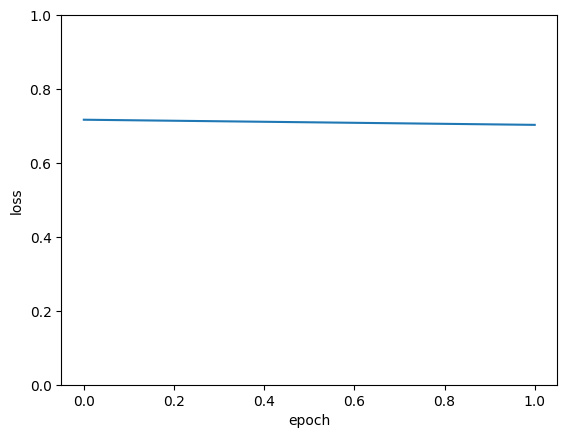

In [9]:
plt.plot(loss_his)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.show()